In [1]:
from tangelo import SecondQuantizedMolecule
from tangelo.algorithms import VQESolver, FCISolver, CCSDSolver, BuiltInAnsatze
from tangelo.toolboxes.ansatz_generator.ansatz import Ansatz

In [49]:
import signal
from contextlib import contextmanager

class TimeoutException(Exception):
    pass

@contextmanager
def time_limit(seconds):

    def signal_handler(signum, frame):
        raise TimeoutException("Timed out!")

    # Register the signal function handler
    signal.signal(signal.SIGALRM, signal_handler)
    # Set the alarm
    signal.alarm(seconds)
    try:
        yield
    finally:
        # Disable the alarm
        signal.alarm(0)

def run_with_timeout(func, args=(), kwargs={}, timeout=10):
    try:
        with time_limit(timeout):
            return func(*args, **kwargs)
    except TimeoutException:
        print(f"Function '{func.__name__}' timed out after {timeout} seconds.")
        return None
    except Exception as e:
        print(f"Function '{func.__name__}' raised an exception: {e}")
        return None

In [3]:
def vqe_simulate(second_quantized_mol):
    vqe_options = {"molecule": second_quantized_mol}
    vqe_solver = VQESolver(vqe_options)
    vqe_solver.build()
    return vqe_solver.simulate()

In [50]:
def vqe_resources(second_quantized_mol):
    vqe_options = {"molecule": second_quantized_mol}
    vqe_solver = VQESolver(vqe_options)
    vqe_solver.build()
    return vqe_solver.get_resources()

In [5]:
def simulate_classically(second_quantized_mol):

    # Uncomment the following lines if FCI simulation is feasible
    # fci_solver = FCISolver(second_quantized_mol)
    # energy_fci = fci_solver.simulate()
    # print(f"FCI energy: \t {energy_fci}")

    ccsd_solver = CCSDSolver(second_quantized_mol)
    energy_ccsd = ccsd_solver.simulate()
    print(f"CCSD energy: \t {energy_ccsd}")

In [51]:
def vqe_resources_with_mappings(molecule, ansatz):
 
    qubit_mappings = ['jw', 'bk', 'scbk']  # List of different qubit mappings
    resources_list = []

    for qm in qubit_mappings:
        # Define VQE options with the given molecule, ansatz, and current qubit mapping
        vqe_options = {"molecule": molecule, "ansatz": ansatz, "qubit_mapping": qm}
        vqe_solver = VQESolver(vqe_options)
        vqe_solver.build()
  

        # Get resources and store in the list
        resources = vqe_solver.get_resources()
        resources_list.append({"qubit_mapping": qm, "resources": resources})

    return resources_list

In [7]:
def vqe_resources_with_ansatze(molecule, ansatze_list):

    resources_list = []

    for az in ansatze_list:
        # Define VQE options with the given molecule and ansatz
        vqe_options = {"molecule": molecule, "ansatz": az, "up_then_down": True}
        vqe_solver = VQESolver(vqe_options)
        vqe_solver.build()


        # Get resources and store in the list
        resources = vqe_solver.get_resources()
        resources_list.append({"ansatz": az, "resources": resources})

    return resources_list

In [52]:
def print_orbital_energies(molecule):

    orbital_energies = molecule.mo_energies
    occupations = molecule.mo_occ

    orbital_info = []
    for idx, (energy, occ) in enumerate(zip(orbital_energies, occupations)):
        orbital_info.append((idx, energy, occ))

    # Display orbital information
    print(f"Number of active electrons: {molecule.n_active_electrons}\n")
    print("Orbital Index | Occupation Number | Orbital Energy (Hartree)")
    print("------------------------------------------------------------")
    for idx, energy, occ in orbital_info:
        print(f"{idx:<13} {occ:<18} {energy}")
    

In [9]:
def KMeans1D_DP(data, K):
    """
    Performs optimal 1D k-means clustering via dynamic programming.
    
    Parameters:
    - data: 1D numpy array
    - K: number of clusters
    
    Returns:
    - labels: numpy array of cluster labels corresponding to the original data order
    """
    import numpy as np
    
    n = len(data)
    # Sort data and keep track of original indices
    sorted_indices = np.argsort(data)
    sorted_data = data[sorted_indices]
    
    # Precompute cumulative sums and cumulative squared sums
    data_cumsum = np.zeros(n+1)
    data_sq_cumsum = np.zeros(n+1)
    for i in range(1, n+1):
        data_cumsum[i] = data_cumsum[i-1] + sorted_data[i-1]
        data_sq_cumsum[i] = data_sq_cumsum[i-1] + sorted_data[i-1]**2
    
    # Initialize the cost and segmentation arrays
    cost = np.full((n+1, K+1), np.inf)
    backtrack = np.zeros((n+1, K+1), dtype=int)
    
    cost[0][0] = 0  # Base case
    
    # Dynamic programming to compute optimal cost
    for i in range(1, n+1):
        for k in range(1, min(i, K)+1):
            for j in range(k-1, i):
                count = i - j
                sum_x = data_cumsum[i] - data_cumsum[j]
                sum_x_sq = data_sq_cumsum[i] - data_sq_cumsum[j]
                mean = sum_x / count
                ssd = sum_x_sq - 2 * mean * sum_x + count * mean**2
                total_cost = cost[j][k-1] + ssd
                if total_cost < cost[i][k]:
                    cost[i][k] = total_cost
                    backtrack[i][k] = j
    
    # Backtracking to assign labels
    labels = np.zeros(n, dtype=int)
    k = K
    i = n
    while k > 0:
        j = backtrack[i][k]
        labels[j:i] = k-1
        i = j
        k -=1
    
    # Map labels back to original data order
    original_labels = np.zeros(n, dtype=int)
    original_labels[sorted_indices] = labels
    
    return original_labels


In [10]:
import numpy as np

def generate_freeze_lists(molecule, k_core, k_virtual):
    """
    Generates multiple freeze lists by clustering core (occupied) and virtual orbitals
    based on their energies using optimal 1D clustering via dynamic programming.

    Parameters:
    - molecule: SecondQuantizedMolecule object representing the molecule.
    - k_core: Number of clusters to form among core (occupied) orbitals.
    - k_virtual: Number of clusters to form among virtual orbitals.

    Returns:
    - freeze_lists: A list of freeze lists (each is a list of orbital indices to freeze).
    """
    orbital_energies = molecule.mo_energies
    occupations = molecule.mo_occ

    orbital_info = []
    for idx, (energy, occ) in enumerate(zip(orbital_energies, occupations)):
        orbital_info.append((idx, energy, occ))

    print(f"Number of active electrons: {molecule.n_active_electrons}")

    # Collect core orbitals (occupation == 2.0)
    core_indices = []
    core_energies = []
    for idx, energy, occ in orbital_info:
        if occ == 2.0:
            core_indices.append(idx)
            core_energies.append(energy)

    core_indices = np.array(core_indices)
    core_energies = np.array(core_energies)

    # Cluster core orbitals using dynamic programming
    if len(core_indices) == 0:
        print("No core orbitals to cluster.")
        core_clusters = {}
        core_cluster_order = []
    else:
        k_core = min(k_core, len(core_indices))
        core_labels = KMeans1D_DP(core_energies, k_core)
        # Group core orbitals by clusters
        core_clusters = {}
        for label in range(k_core):
            cluster_indices = core_indices[core_labels == label]
            core_clusters[label] = (cluster_indices)
        core_cluster_order = (range(k_core))
        # Print cluster info
        print(f"\nClustered core orbitals into {k_core} groups:")
        for label in core_cluster_order:
            indices = core_clusters[label]
            energies = [orbital_energies[i] for i in indices]
            print(f"Core Cluster {label+1}: Orbitals {indices}, Energies {energies}")

    # Collect virtual orbitals (occupation == 0.0)
    virtual_indices = []
    virtual_energies = []
    for idx, energy, occ in orbital_info:
        if occ == 0.0:
            virtual_indices.append(idx)
            virtual_energies.append(energy)

    virtual_indices = np.array(virtual_indices)
    virtual_energies = np.array(virtual_energies)

    # Cluster virtual orbitals using dynamic programming
    if len(virtual_indices) == 0:
        print("No virtual orbitals to cluster.")
        virtual_clusters = {}
        virtual_cluster_order = []
    else:
        k_virtual = min(k_virtual, len(virtual_indices))
        virtual_labels = KMeans1D_DP(virtual_energies, k_virtual)
        # Group virtual orbitals by clusters
        virtual_clusters = {}
        for label in range(k_virtual):
            cluster_indices = virtual_indices[virtual_labels == label]
            virtual_clusters[label] = (cluster_indices)
        virtual_cluster_order = (range(k_virtual))
        # Print cluster info
        print(f"\nClustered virtual orbitals into {k_virtual} groups:")
        for label in virtual_cluster_order:
            indices = virtual_clusters[label]
            energies = [orbital_energies[i] for i in indices]
            print(f"Virtual Cluster {label+1}: Orbitals {indices}, Energies {energies}")

    # Generate combinations according to the specified logic
    freeze_lists = []
    num_core_clusters = len(core_cluster_order)
    num_virtual_clusters = len(virtual_cluster_order)

    for c in range(1, num_core_clusters + 1):
        # Core clusters to include
        core_clusters_to_include = core_cluster_order[:c]
        core_orbitals_to_freeze = []
        for label in core_clusters_to_include:
            core_orbitals_to_freeze.extend(core_clusters[label])
        for v in range(0, num_virtual_clusters + 1):
            # Virtual clusters to include
            virtual_clusters_to_include = virtual_cluster_order[-v:] if v > 0 else []
            virtual_orbitals_to_freeze = []
            for label in virtual_clusters_to_include:
                virtual_orbitals_to_freeze.extend(virtual_clusters[label])
            freeze_list = core_orbitals_to_freeze + virtual_orbitals_to_freeze
            freeze_lists.append(freeze_list)
            print(f"\nGenerated freeze list with core clusters {core_clusters_to_include} and virtual clusters {virtual_clusters_to_include}")
            print(f"Freeze list orbitals: {freeze_list}")

    return freeze_lists



In [ ]:
def print_molecule_properties(name, molecule):
    print(f"=== {name} Properties ===")
    print(f"Charge (q): {molecule.q}")
    print(f"Spin (2S): {molecule.spin}")
    print(f"Number of Electrons: {molecule.n_electrons}")
    print(f"Number of Active Electrons: {molecule.n_active_electrons}")
    print(f"Basis Set: {molecule.basis}")
    print(f"Frozen Orbitals: {molecule.frozen_orbitals}")
    print("--------------------------\n")

In [2]:
# Define the LiH molecule geometry
LiH = [('Li', (0, 0, 0)), ('H', (0, 0, 1.5949))]

# Create a SecondQuantizedMolecule instance for LiH
mol_LiH = SecondQuantizedMolecule(LiH, q=0, spin=0, basis="sto-3g")

# Define the Cr element
Cr= [['Cr', (0, 0, 0)]]

# Create a SecondQuantizedMolecule instance for Cr_VI
Cr_VI = SecondQuantizedMolecule(Cr, q=6, spin=0, basis="LANL2DZ", frozen_orbitals=None)

# Create a SecondQuantizedMolecule instance for Cr_III
Cr_III = SecondQuantizedMolecule(Cr, q=3, spin=3, basis="LANL2DZ", frozen_orbitals=None)

print_molecule_properties("LiH", mol_LiH)
print_molecule_properties("Cr_III", Cr_III)
print_molecule_properties("Cr_VI", Cr_VI)

NameError: name 'SecondQuantizedMolecule' is not defined

In [12]:
def print_molecule_properties(name, molecule):
    print(f"=== {name} Properties ===")
    print(f"Charge (q): {molecule.q}")
    print(f"Spin (2S): {molecule.spin}")
    print(f"Number of Electrons: {molecule.n_electrons}")
    print(f"Number of Active Electrons: {molecule.n_active_electrons}")
    print(f"Basis Set: {molecule.basis}")
    print(f"Frozen Orbitals: {molecule.frozen_orbitals}")
    print("--------------------------\n")

In [55]:
print_molecule_properties("LiH", mol_LiH)
print_molecule_properties("Cr_III", Cr_III)
print_molecule_properties("Cr_VI", Cr_VI)

In [14]:
print_orbital_energies(Cr_III)

Number of active electrons: 21

Orbital Index | Occupation Number | Orbital Energy (Hartree)
------------------------------------------------------------
0             2.0                -12.4503881687681
1             2.0                -9.656066956243706
2             2.0                -9.656066245887727
3             2.0                -9.656065523000239
4             2.0                -6.481227314816717
5             2.0                -6.481226829443148
6             2.0                -6.481226332532031
7             2.0                -6.4795267996509205
8             2.0                -6.479526792822202
9             1.0                -1.8801482151466438
10            1.0                -0.7975336371829891
11            1.0                -0.7975336207140077
12            0.0                -0.7535817686915726
13            0.0                -0.7535812855594194
14            0.0                -0.7535807582595245
15            0.0                -0.7031960306007854
16     

In [56]:
freeze_lists = generate_freeze_lists(Cr_III, 8, 4)


In [57]:
"""Important: Sort list and then limit to 1 minute
   Also maybe don't cluster the core elctrons?"""
frozen_molecules_dict = {}

for idx, freeze_list in enumerate(freeze_lists, start=1):
    int_freeze_list = [int(x) for x in freeze_list]

    
    freeze_list_key = tuple(int_freeze_list)
    
    # Create a new SecondQuantizedMolecule with frozen orbitals
    try:
        Cr_III_custom_frozen = SecondQuantizedMolecule(
            Cr,
            q=3,
            spin=3,
            basis="LANL2DZ",
            frozen_orbitals=int_freeze_list
        )
        
        if len(int_freeze_list) > 8:
            print(f"\nCreating frozen molecule for Freeze List {idx}: {int_freeze_list}")
            resources = vqe_resources(Cr_III_custom_frozen)
            print(resources)
            if resources["circuit_width"] < 15:
                vqe_energy = vqe_simulate(Cr_III_custom_frozen)
                print(f"vqe_energy = {vqe_energy}")
    except TypeError as e:
        print(f"TypeError for Freeze List {idx}: {e}")
    except Exception as e:
        print(f"Unexpected error for Freeze List {idx}: {e}")

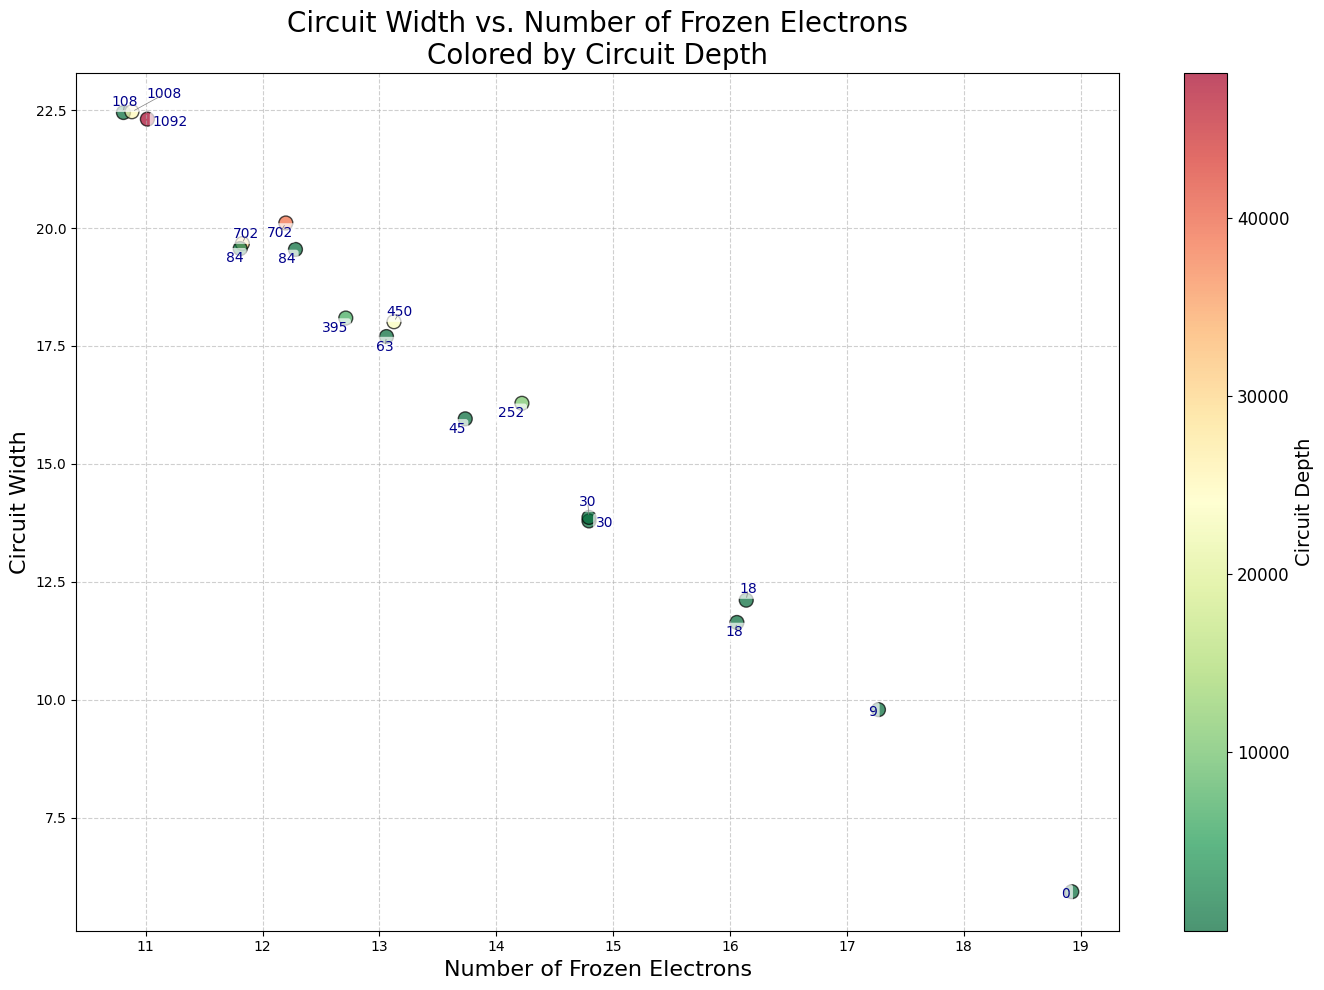

In [41]:
import numpy as np


# Initialize the dictionary to store freeze lists and their resources
frozen_molecules_dict = {}

# Assume freeze_lists is predefined
# Example:
# freeze_lists = [
#     [0],
#     [0, 19, 20, 21],
#     [0, 16, 17, 18, 19, 20, 21],
#     ...
# ]

# Sort freeze_lists by length in descending order
freeze_list_sorted = sorted(freeze_lists, key=len, reverse=True)

# Define the timeout duration in seconds
TIMEOUT_DURATION = 10  # Adjust as needed

# Define the circuit width threshold
CIRCUIT_WIDTH_THRESHOLD = 10  # Adjust based on your requirements

for idx, freeze_list in enumerate(freeze_list_sorted, start=1):
    # Convert all elements in freeze_list to integers
    int_freeze_list = [int(x) for x in freeze_list]
    
    # Create a tuple from the freeze list to use as a dictionary key
    freeze_list_key = tuple(int_freeze_list)
    
    try:
        # Create a new SecondQuantizedMolecule with frozen orbitals
        Cr_III_custom_frozen = SecondQuantizedMolecule(
            Cr,
            q=3,
            spin=3,
            basis="LANL2DZ",
            frozen_orbitals=int_freeze_list
        )
        
        # Only process freeze lists with more than 8 frozen electrons
        
        print(f"\nCreating frozen molecule for Freeze List {idx}: {int_freeze_list}")
        
        # Calculate resources with timeout
        resources = run_with_timeout(vqe_resources, args=(Cr_III_custom_frozen,), timeout=TIMEOUT_DURATION)
        
        if resources is not None:
            print(resources)
            
            # Insert the freeze list and its resources into the dictionary
            frozen_molecules_dict[freeze_list_key] = resources
            
            # Optionally, perform VQE simulation if circuit_width is below threshold
            if resources.get("circuit_width", 0) < CIRCUIT_WIDTH_THRESHOLD:
                vqe_energy = run_with_timeout(vqe_simulate, args=(Cr_III_custom_frozen,), timeout=TIMEOUT_DURATION)
                if vqe_energy is not None:
                    print(f"vqe_energy = {vqe_energy}")
        else:
            print(f"Skipping Freeze List {freeze_list_key} due to timeout or error in resource calculation.")
                
    except TypeError as e:
        print(f"TypeError for Freeze List {idx}: {e}")
    except Exception as e:
        print(f"Unexpected error for Freeze List {idx}: {e}")

# Optional: Print the complete dictionary after processing
print("\n--- Frozen Molecules Dictionary ---")
for freeze, res in frozen_molecules_dict.items():
    print(f"Freeze List {freeze}: {res}")


In [58]:
import matplotlib.pyplot as plt

# Assume frozen_molecules_dict is defined as per your previous code
# Example:
frozen_orbs_dict = frozen_molecules_dict
# Prepare data for plotting
num_frozen_electrons = [len(freeze) for freeze in frozen_orbs_dict.keys()]
circuit_widths = [res['circuit_width'] for res in frozen_orbs_dict.values()]
circuit_depths = [res['circuit_depth'] for res in frozen_orbs_dict.values()]
vqe_variational_parameters = [res['vqe_variational_parameters'] for res in frozen_orbs_dict.values()]

# Create scatter plot
plt.figure(figsize=(12, 8))
scatter = plt.scatter(
    num_frozen_electrons,
    circuit_widths,
    c=circuit_depths,
    cmap='viridis',
    s=150,
    alpha=0.7,
    edgecolor='k'
)

# Add colorbar for circuit depth
cbar = plt.colorbar(scatter)
cbar.set_label('Circuit Depth', fontsize=12)

# Add labels and title
plt.xlabel('Number of Frozen Electrons', fontsize=14)
plt.ylabel('Circuit Width', fontsize=14)
plt.title('Circuit Width vs. Number of Frozen Electrons\nColored by Circuit Depth', fontsize=16)

# Annotate each point with its VQE Variational Parameters
for freeze, res in frozen_molecules_dict.items():
    plt.annotate(
        res['vqe_variational_parameters'],
        (len(freeze), res['circuit_width']),
        textcoords="offset points",
        xytext=(0, 10),
        ha='center',
        fontsize=10,
        fontweight='bold'
    )

plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

Timed out!


=== LiH Properties ===
Charge (q): 0
Spin (2S): 0
Number of Electrons: 4
Number of Active Electrons: 2
Basis Set: sto-3g
Frozen Orbitals: frozen_core
--------------------------

=== Cr_III Properties ===
Charge (q): 3
Spin (2S): 3
Number of Electrons: 21
Number of Active Electrons: 21
Basis Set: LANL2DZ
Frozen Orbitals: None
--------------------------

=== Cr_VI Properties ===
Charge (q): 6
Spin (2S): 0
Number of Electrons: 18
Number of Active Electrons: 18
Basis Set: LANL2DZ
Frozen Orbitals: None
--------------------------
